In [1]:
import os

initial_data = {}

def read_files_in_directory(directory):
    coord_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            coords = []
            file_path = os.path.join(root, file)
            # Check if it's a text file (you can adjust this)
            if file.endswith('.txt'):
                with open(file_path, 'r') as f:
                    content = f.readlines()
                    for i in content:
                        xy = i.split()
                        coords.append((int(xy[0]), int(xy[1])))
            coord_list.append(coords)

            initial_data[directory[-1::]] = coord_list

def iterate_directories(directory):
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            print(f"Directory: {dir_path}")
            read_files_in_directory(dir_path)

iterate_directories('./mal-htr')

# print(initial_data)

Directory: ./mal-htr/ഘ
Directory: ./mal-htr/ക
Directory: ./mal-htr/ങ
Directory: ./mal-htr/ഖ
Directory: ./mal-htr/ഗ


/tmp/ipykernel_104888/698726291.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


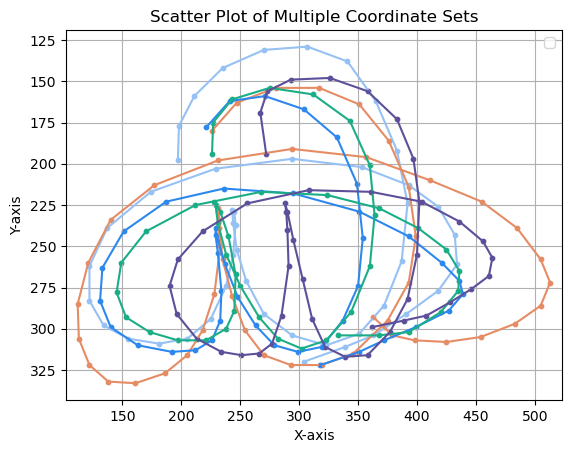

In [8]:
import matplotlib.pyplot as plt
import random

def plot_letters(coordinates_list):

    x_list = []
    y_list = []
    
    for c in coordinates_list:
        x, y = zip(*c)
        x_list.append(x)
        y_list.append(y)

    plt.xlim(min(x_list[0]), max(x_list[0]))
    plt.ylim(min(y_list[0]), max(y_list[0]))

    for x, y in zip(x_list, y_list):
        color = (random.random(), random.random(), random.random())
        plt.scatter(x, y, color=color, s=10)  # First set in blue
        plt.plot(x, y, color=color, linestyle='-', marker='o', markersize=1)
    
        plt.xlim(min(min(x), plt.xlim()[0] + 10) - 10, max(max(x), plt.xlim()[1] - 10) + 10)
        plt.ylim(min(min(y), plt.ylim()[0] + 10) - 10, max(max(y), plt.ylim()[1] - 10) + 10)
    
    # Invert y-axis if needed
    # plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    
    # Add titles and labels
    plt.title('Scatter Plot of Multiple Coordinate Sets')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    # Show grid
    plt.grid()
    
    # Add a legend
    plt.legend()
    
    # Display the plot
    plt.show()

plot_letters(initial_data['ക'][10:15])

/tmp/ipykernel_104888/698726291.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


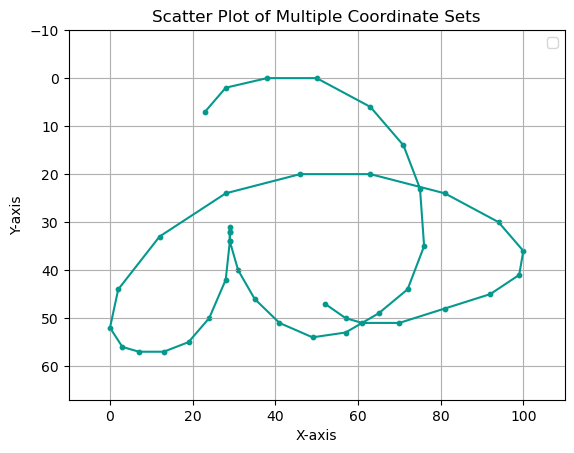

In [9]:
def normalize_coordinates(coordinates):
    x_list, y_list = zip(*coordinates)
    x_min = min(x_list)
    y_min = min(y_list)

    x_max = max(x_list)
    y_max = max(y_list)

    n_range = 100

    x_range = x_max - x_min
    y_range = y_max - y_min

    n_factor_x = x_range / n_range
    n_factor_y = y_range / n_range

    n_factor = n_factor_x
    
    if y_range > x_range:
        n_factor = n_factor_y

    n_min_x = int(x_min / n_factor)
    n_min_y = int(y_min / n_factor)

    normalized_coordinates = []

    for c in coordinates:
        p = (int(c[0] / n_factor) - n_min_x, int(c[1] / n_factor) - n_min_y)
        normalized_coordinates.append(p)

    return normalized_coordinates

plot_letters([normalize_coordinates(initial_data['ക'][18])])

/tmp/ipykernel_104888/698726291.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


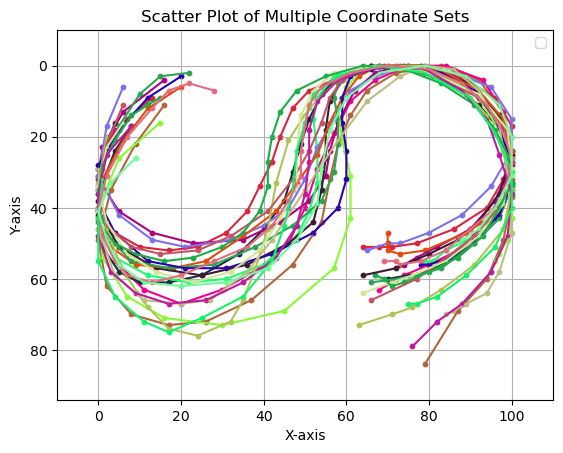

In [12]:
normalized_coordinates_list = []

for c in initial_data['ഗ']:
    normalized_coordinates_list.append(normalize_coordinates(c))

plot_letters(normalized_coordinates_list)